In [23]:
# import packages
import json
from typing import Tuple, List
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator, SASEvaluator
from haystack.evaluation import EvaluationRunResult

from tqdm import tqdm
from pathlib import Path
from openai import BadRequestError
from getpass import getpass
import os

In [27]:
from dotenv import load_dotenv
load_dotenv()

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
generator = OpenAIGenerator(model="gpt-3.5-turbo")

In [24]:
# set base path
base_path = "../data/evaluation"

In [118]:
# import data
import json
from typing import Tuple, List

def read_question_answers() -> Tuple[List[str], List[str]]:
    with open(base_path+"/eval_data.json", "r") as f:
        data = json.load(f)
        questions = data["questions"]
        answers = data["ground_truths"]
    return questions, answers

questions, answers = read_question_answers()

In [30]:
# document loading, indexing and embedding
def indexing(embedding_model: str, chunk_size: int):
    files_path = base_path+"/eval_documents"
    document_store = InMemoryDocumentStore()
    pipeline = Pipeline()
    pipeline.add_component("converter", PyPDFToDocument())
    pipeline.add_component("cleaner", DocumentCleaner())
    pipeline.add_component("splitter", DocumentSplitter(split_length=chunk_size))  # splitting by word
    pipeline.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP))
    pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(embedding_model))
    pipeline.connect("converter", "cleaner")
    pipeline.connect("cleaner", "splitter")
    pipeline.connect("splitter", "embedder")
    pipeline.connect("embedder", "writer")
    pdf_files = [files_path+"/"+f_name for f_name in os.listdir(files_path)]
    pipeline.run({"converter": {"sources": pdf_files}})

    return document_store


In [32]:
# define basic RAG pipeline
def basic_rag(document_store, embedding_model, top_k=2):
    template = """
        You have to answer the following question based on the given context information only.
        If the context is empty or just a '\n' answer with None, example: "None".

        Context:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """

    basic_rag = Pipeline()
    basic_rag.add_component("query_embedder", SentenceTransformersTextEmbedder(
        model=embedding_model, progress_bar=False
    ))
    basic_rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=top_k))
    basic_rag.add_component("prompt_builder", PromptBuilder(template=template))
    basic_rag.add_component("llm", OpenAIGenerator(model="gpt-3.5-turbo"))
    basic_rag.add_component("answer_builder", AnswerBuilder())

    basic_rag.connect("query_embedder", "retriever.query_embedding")
    basic_rag.connect("retriever", "prompt_builder.documents")
    basic_rag.connect("prompt_builder", "llm")
    basic_rag.connect("llm.replies", "answer_builder.replies")
    basic_rag.connect("llm.meta", "answer_builder.meta")
    basic_rag.connect("retriever", "answer_builder.documents")

    return basic_rag

def run_basic_rag(doc_store, sample_questions, embedding_model, top_k):
    """
    A function to run the basic rag model on a set of sample questions and answers
    """

    rag = basic_rag(document_store=doc_store, embedding_model=embedding_model, top_k=top_k)

    predicted_answers = []
    retrieved_contexts = []
    for q in tqdm(sample_questions):
        try:
            response = rag.run(
                data={"query_embedder": {"text": q}, "prompt_builder": {"question": q}, "answer_builder": {"query": q}})
            predicted_answers.append(response["answer_builder"]["answers"][0].data)
            retrieved_contexts.append([d.content for d in response['answer_builder']['answers'][0].documents])
        except BadRequestError as e:
            print(f"Error with question: {q}")
            print(e)
            predicted_answers.append("error")
            retrieved_contexts.append(retrieved_contexts)

    return retrieved_contexts, predicted_answers

In [33]:
def run_evaluation(sample_questions, sample_answers, retrieved_contexts, predicted_answers, embedding_model):
    context_relevance = ContextRelevanceEvaluator(raise_on_failure=False)
    faithfulness = FaithfulnessEvaluator(raise_on_failure=False)
    sas = SASEvaluator(model=embedding_model)
    sas.warm_up()

    results = {
        "context_relevance": context_relevance.run(sample_questions, retrieved_contexts),
        "faithfulness": faithfulness.run(sample_questions, retrieved_contexts, predicted_answers),
        "sas": sas.run(predicted_answers, sample_answers),
    }

    inputs = {'questions': sample_questions, "true_answers": sample_answers, "predicted_answers": predicted_answers}

    return results, inputs

In [34]:
def parameter_tuning(questions, answers, out_path: str):
    """
    Run the basic RAG model with different parameters, and evaluate the results.

    The parameters to be tuned are: embedding model, top_k, and chunk_size.
    """
    embedding_models = {
        "sentence-transformers/all-MiniLM-L6-v2",
        "sentence-transformers/msmarco-distilroberta-base-v2",
        "sentence-transformers/all-mpnet-base-v2"
    }
    top_k_values = [1, 2, 3]
    chunk_sizes = [64, 128, 256]

    # create results directory if it does not exist using Pathlib
    out_path = Path(out_path)
    out_path.mkdir(exist_ok=True)

    for embedding_model in embedding_models:
        for chunk_size in chunk_sizes:
            print(f"Indexing documents with {embedding_model} model with a chunk_size={chunk_size}")
            doc_store = indexing(embedding_model, chunk_size)
            for top_k in top_k_values:
                name_params = f"{embedding_model.split('/')[-1]}__top_k:{top_k}__chunk_size:{chunk_size}"
                print(name_params)
                print("Running RAG pipeline")
                retrieved_contexts, predicted_answers = run_basic_rag(doc_store, questions, embedding_model, top_k)
                print(f"Running evaluation")
                results, inputs = run_evaluation(questions, answers, retrieved_contexts, predicted_answers, embedding_model)
                eval_results = EvaluationRunResult(run_name=name_params, inputs=inputs, results=results)
                eval_results.score_report().to_csv(f"{out_path}/score_report_{name_params}.csv",index=False)
                eval_results.to_pandas().to_csv(f"{out_path}/detailed_{name_params}.csv",index=False)

In [ ]:
parameter_tuning(questions, answers, "../data/evaluation/results")

In [88]:
import re

def parse_results(f_name: str):
    pattern = r"score_report_(.*?)__top_k:(\d+)__chunk_size:(\d+)\.csv"
    match = re.search(pattern, f_name)
    if match:
        embeddings_model = match.group(1)
        top_k = int(match.group(2))
        chunk_size = int(match.group(3))
        return embeddings_model, top_k, chunk_size
    else:
        print("No match found")

In [89]:
import pandas as pd

def read_scores(path: str):
    all_scores = []
    for root, dirs, files in os.walk(path):
        for f_name in files:
            if not f_name.startswith("score_report"):
                continue

            embeddings_model, top_k, chunk_size = parse_results(f_name)
            df = pd.read_csv(path+"/"+f_name)
            df_transposed = df.T
            df_transposed.columns = df_transposed.iloc[0]
            df_transposed = df_transposed[1:]

            # Add new columns
            df_transposed['embeddings'] = embeddings_model
            df_transposed['top_k'] = top_k
            df_transposed['chunk_size'] = chunk_size

            all_scores.append(df_transposed)

    df = pd.concat(all_scores)
    df.reset_index(drop=True, inplace=True)
    df.rename_axis(None, axis=1, inplace=True)

    return df

In [117]:
df = read_scores('../data/evaluation/results/')

In [107]:
#df.sort_values(by=['embeddings', 'chunk_size', 'top_k'], ascending=[True, True, True])
df.sort_values(by=['context_relevance'], ascending=[False])

,context_relevance,faithfulness,sas,embeddings,top_k,chunk_size
2,0.996094,0.78125,0.624541,all-mpnet-base-v2,2,256
5,0.979167,0.8125,0.571073,msmarco-distilroberta-base-v2,2,256
19,0.956818,0.90625,0.669886,msmarco-distilroberta-base-v2,2,128
24,0.942708,0.8125,0.701483,all-MiniLM-L6-v2,2,256
26,0.9375,0.84375,0.699926,all-MiniLM-L6-v2,3,256
12,0.936648,0.90625,0.645101,all-MiniLM-L6-v2,2,128
15,0.898958,0.75,0.570668,msmarco-distilroberta-base-v2,1,128
7,0.897222,0.84375,0.615157,msmarco-distilroberta-base-v2,3,256
14,0.885417,0.9375,0.600564,all-mpnet-base-v2,2,128
17,0.884135,0.75,0.672101,msmarco-distilroberta-base-v2,3,128


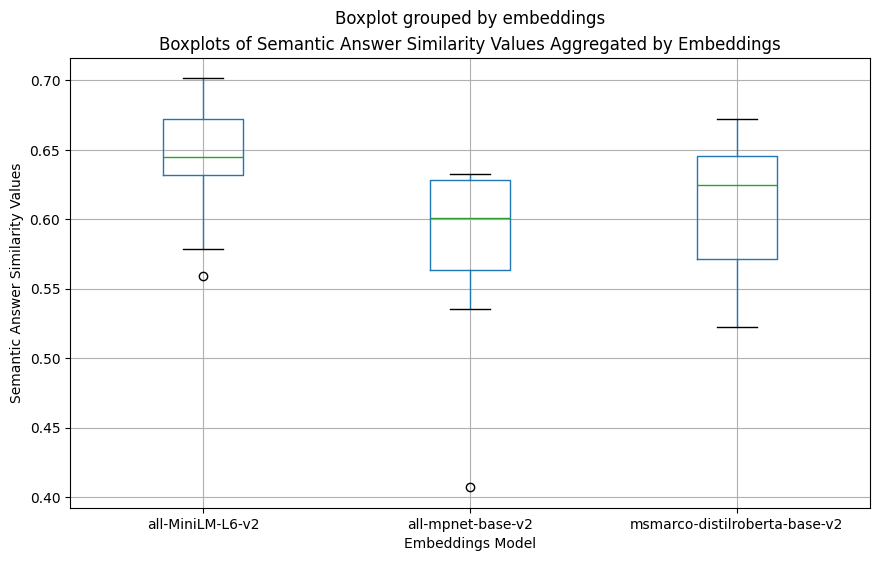

In [116]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(column='sas', by='embeddings', ax=ax)

plt.xlabel("Embeddings Model")
plt.ylabel("Semantic Answer Similarity Values")
plt.title("Boxplots of Semantic Answer Similarity Values Aggregated by Embeddings")

#plt.show()
plt.savefig("../figures/boxplot.png")

In [111]:
# inspect queries for one parameter constellation
detailed_best_sas_df = pd.read_csv("results/detailed_all-mpnet-base-v2__top_k:3__chunk_size:256.csv")

In [112]:
detailed_best_sas_df

,questions,true_answers,predicted_answers,context_relevance,faithfulness,sas
0,What does Paragraph 2 of Schedule 5 of the PFM...,Paragraph 2 of Schedule 5 of the PFMA mandates...,Paragraph 2 of Schedule 5 of the PFMA mandates...,1.000000,1.0,0.927684
1,How did the actual Non-Tax Revenue (NTR) colle...,The actual Non-Tax Revenue (NTR) collection fo...,The actual Non-Tax Revenue (NTR) collection fo...,0.833333,1.0,0.931899
2,How many outputs were fully implemented accord...,Five outputs were fully implemented.,Five outputs were fully implemented according ...,1.000000,1.0,0.923353
3,What happens if an Accounting Officer does not...,If an Accounting Officer does not follow the r...,The Accounting Officer shall be held personall...,1.000000,1.0,0.847525
4,"What percentage of wage, pension and gratuity ...",24% was underspent,24%,1.000000,1.0,0.600921
5,How many pieces of land lacked Land titles?,76 pieces of land lacked titles,76 pieces of land lacked Land titles.,1.000000,1.0,0.907252
6,How many pensioners were underpaid and how much?,49 pensioners were underpaid amount equivalent...,55 pensioners were underpaid a total of UGX.90...,1.000000,1.0,0.832352
7,What is the danger of not maintaining a risk r...,Failure to maintain risk registers implies tha...,The danger of not maintaining a risk register ...,1.000000,1.0,0.860600
8,What accounts for domestic arrears in Fort Por...,Under Budgeting for Domestic Arrears where for...,NaN,0.909091,0.0,0.119042
9,How much was spent on social benefits vis-as-...,"UGX. 192,228,586 was spent against the planned...",NaN,0.833333,0.0,0.087135
